In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import gcsfs
import fsspec
import xesmf as xe
import warnings
import fiona
import rasterio
import regionmask
warnings.filterwarnings('ignore')

import geopandas as gpd


# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
def compare_mean_std_biases(gcm_basins, era_basins):
    means_gcms = gcm_basins.iloc[0:]['mean'].values
    stds_gcms = gcm_basins.iloc[0:]['hydrologic'].values
    mean_errors = np.array([means_gcms - gcm_basins.iloc[0:]['lower_quar'],
                   gcm_basins.iloc[0:]['upper_quar'] - means_gcms])
    std_errors = np.array([stds_gcms - gcm_basins.iloc[0:]['lower_qu_2'],
                   gcm_basins.iloc[0:]['upper_qu_2'] - stds_gcms])
    means_era = era_basins.iloc[0:]['mean'].values
    std_era = era_basins.iloc[0:]['hydrologic'].values
    mean_biases = ((means_gcms - means_era)/means_era)*100
    mean_bias_errors = (mean_errors/np.expand_dims(means_era, 0))*100
    std_biases = stds_gcms - std_era
    return mean_biases, std_biases, mean_bias_errors, std_errors

In [3]:
def calc_basin_variable(in_variables, metric, masks, basins_gdf_in):
    '''Input: 
    in_variables: a list of datasets; could be just one (for mean_temp)
    or two (precip and runoff for runoff_ratio) datasets with variables 
    metric: 'runoff_ratio' or 'mean_temp'
    '''
    if metric == 'runoff_ratio':
        precip_da = in_variables[0]
        runoff_da = in_variables[1]
        precip_da = precip_da.rename({'lon': 'longitude',
                           'lat': 'latitude'})
        precip_da = precip_da.assign_coords(longitude=(((precip_da.longitude + 180) % 360) 
                                             - 180)).sortby('longitude')

        runoff_da = runoff_da.rename({'lon': 'longitude',
                           'lat': 'latitude'})
        runoff_da = runoff_da.assign_coords(longitude=(((runoff_da.longitude + 180) % 360) 
                                             - 180)).sortby('longitude')
    elif metric == 'mean_temp':
        temp_da = in_variables[0]
        temp_da = temp_da.rename({'lon': 'longitude',
                           'lat': 'latitude'})
        temp_da = temp_da.assign_coords(longitude=(((temp_da.longitude + 180) % 360) 
                                             - 180)).sortby('longitude')

    basins_gdf_out = basins_gdf_in.copy(deep=True)
    basins_gdf_out[metric] = np.nan
    lat = masks.latitude.values
    lon = masks.longitude.values
    for ID_REGION in basins_gdf_out.index.values:
        sel_mask = masks.where(masks == ID_REGION).values
        if (~np.isnan(sel_mask)).sum() < 10:
            print(basins_gdf_out.iloc[ID_REGION]['NAME'])
            continue
        id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
        id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
        if metric=='runoff_ratio':
            basin_average_precip = precip_da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                            longitude = slice(id_lon[0], id_lon[-1])
                           ).compute().where(masks == ID_REGION).mean(dim=['latitude', 'longitude'])
            basin_average_runoff = runoff_da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                            longitude = slice(id_lon[0], id_lon[-1])
                           ).compute().where(masks == ID_REGION).mean(dim=['latitude', 'longitude'])
        elif metric=='mean_temp':
            basin_average_temp = temp_da.sel(latitude = slice(id_lat[0], id_lat[-1]), 
                            longitude = slice(id_lon[0], id_lon[-1])
                           ).compute().where(masks == ID_REGION).mean(dim=['latitude', 'longitude'])
        # also add total runoff as a freebie
        if metric == 'runoff_ratio':
            basins_gdf_out.at[ID_REGION, metric] = basin_average_runoff.ro.values/basin_average_precip.tp.values
        elif metric == 'mean_temp':
            basins_gdf_out.at[ID_REGION, metric] = basin_average_temp.t2m.values
        
    return basins_gdf_out

In [4]:
PATH_TO_SHAPEFILE = 'basins_with_hydrologic_ranges_quartiles.dbf'
basins_to_test = gpd.read_file(PATH_TO_SHAPEFILE)
# Remove the basins that don't have geometries attached to them
basins_to_test = basins_to_test[basins_to_test.geometry!=None]
basins_to_test = basins_to_test[~np.isnan(basins_to_test['mean'])]
basins_to_test.index = basins_to_test['NAME']

In [5]:
era_basins = gpd.read_file('basins_era_range.dbf') #_range
era_basins = era_basins[era_basins.geometry!=None]
era_basins = era_basins[~np.isnan(era_basins['mean'])]

In [6]:
era5_precip = xr.open_dataset('era5_monthly_tp_cesm2grid.nc')
era5_runoff = xr.open_dataset('era5_monthly_runoff_cesm2grid.nc')
era5_temp = xr.open_dataset('era5_mean_t2m_cesm2grid.nc')

In [7]:
mask = xr.open_dataset('basin_masks.nc')

In [8]:
new_basins = calc_basin_variable([era5_precip.mean(dim='time'), era5_runoff.mean(dim='time')], 
                                     'runoff_ratio',
                                     mask.region, era_basins)
new_basins = calc_basin_variable([era5_temp], 'mean_temp', mask.region, new_basins)
new_basins = new_basins[~new_basins.duplicated(['NAME'], keep='last')]
new_basins = new_basins[new_basins['NAME']!='Void']
new_basins.index = new_basins['NAME']
new_basins['mean_runoff'] = new_basins['mean']*new_basins['Sufficient']

In [9]:
mean_biases, std_biases, \
mean_bias_errors, std_errors = compare_mean_std_biases(basins_to_test[new_basins['Sufficient'] > 9], 
                                                       new_basins[new_basins['Sufficient'] > 9])

In [11]:
def scatter_errorbar_plot(x_placement, y_placement, error_bars, 
                          labels, colors, sizes, x_limits, y_limits,
                         x_label, y_label, c_label, fig_path):
    # first plot all basins
    plt.figure(figsize=(12,6))
    plt.errorbar(x_placement, 
                 y_placement, 
                 yerr=error_bars, fmt= 'k.', markersize=0, elinewidth=0.5, capsize=0, alpha=0.5)
    scatterplot = plt.scatter(x_placement, 
                 y_placement, 
                s=sizes,
               c=colors)
    for i in range(len(y_placement)):
        if y_placement[i] <y_limits[1]:
            if sizes[i] > 100:
                plt.text(x_placement[i], 
                         y_placement[i], 
                         labels[i], size=8)
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.axhline(0, color='k')
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    cbar = plt.colorbar(scatterplot, )
    cbar.set_label(label=c_label, size=18)
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    from matplotlib.patches import Circle

    legend_elements = [Line2D([0], [0], color='k', lw=1, label='Interquartile range', alpha=0.5,), 
                      Line2D(range(1), range(1), color='w', marker='o', markerfacecolor="darkcyan", 
                             label='River basin (size indicates annual runoff)', markersize=12),]

    # Create the figure
    plt.legend(handles=legend_elements, loc='upper left')
    plt.savefig(fig_path, format='svg')

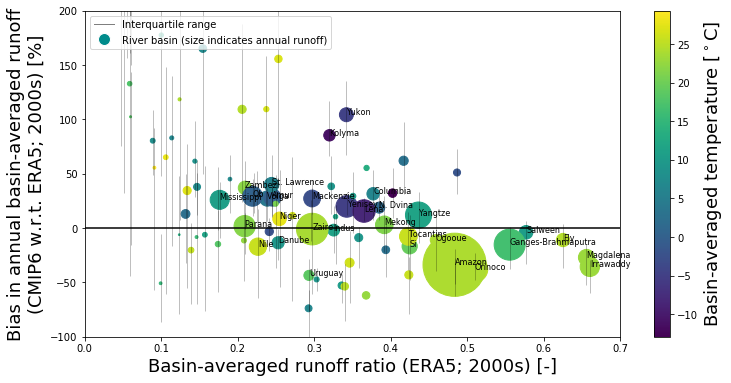

In [12]:
scatter_errorbar_plot(new_basins[new_basins['Sufficient'] > 9]['runoff_ratio'].values,
                     mean_biases,mean_bias_errors,
                      new_basins[new_basins['Sufficient'] > 9]['NAME'].values,
                      new_basins['mean_temp'][new_basins['Sufficient'] >9].values-273.15,
                     (new_basins['mean']*new_basins['Sufficient'])[new_basins['Sufficient'] > 9 ].values*100,
                      [0,0.7],
                      [-100,200],
                      'Basin-averaged runoff ratio (ERA5; 2000s) [-]',
                       'Bias in annual basin-averaged runoff\n(CMIP6 w.r.t. ERA5; 2000s) [%]' ,
                      'Basin-averaged temperature [$^\circ$C]',
                      '../figures/basin_scatter_plot_mean_smaller.svg')

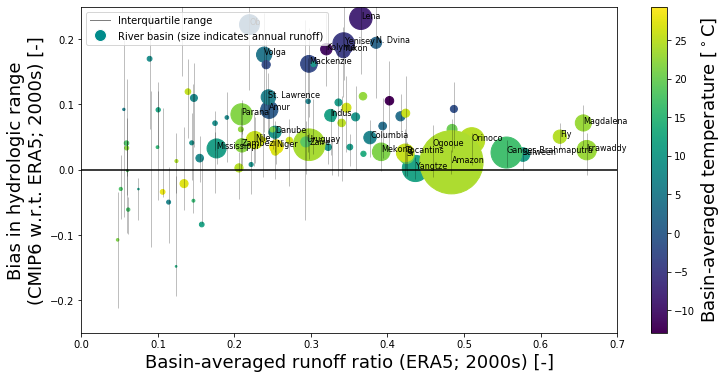

In [13]:
scatter_errorbar_plot(new_basins[new_basins['Sufficient'] > 9]['runoff_ratio'].values,
                     std_biases,
                      std_errors,
                      new_basins[new_basins['Sufficient'] > 9]['NAME'].values,
                      new_basins['mean_temp'][new_basins['Sufficient'] >9].values-273.15,
                     (new_basins['mean']*new_basins['Sufficient'])[new_basins['Sufficient'] > 9 ].values*100,
                      [0,0.7],
                      [-0.25,0.25],
                      'Basin-averaged runoff ratio (ERA5; 2000s) [-]',
                      'Bias in hydrologic range\n(CMIP6 w.r.t. ERA5; 2000s) [-]',
                      'Basin-averaged temperature [$^\circ$C]',
                      '../figures/basin_scatter_plot_h_range_smaller.svg')

# now make the same plots but for gcm changes 

In [14]:
# first load in a single gcm projection

In [15]:
# then loop and add them all together

In [16]:
gpd_dict = {}
means, h_ranges = [], []

for gcm in ['CAMS.CAMS-CSM1-0', 'BCC.BCC-CSM2-MR',
             'CSIRO-ARCCSS.ACCESS-CM2', 'EC-Earth-Consortium.EC-Earth3-Veg',
             'INM.INM-CM4-8', 'INM.INM-CM5-0', 'MIROC.MIROC-ES2L',
            'MRI.MRI-ESM2-0', 'NIMS-KMA.KACE-1-0-G',
             'UA.MCM-UA-1-0', 'NOAA-GFDL.GFDL-CM4',
            'NCAR.CESM2', 'CSIRO.ACCESS-ESM1-5',
             'MPI-M.MPI-ESM1-2-LR', 'MIROC.MIROC6',
             'FIO-QLNM.FIO-ESM-2-0', 'CCCma.CanESM5-CanOE',
             'CNRM-CERFACS.CNRM-ESM2-1', 'CNRM-CERFACS.CNRM-CM6-1',
                    'MOHC.UKESM1-0-LL', 'NCAR.CESM2-WACCM', 'IPSL.IPSL-CM6A-LR']:
    PATH_TO_SHAPEFILE = '{}_ssp585_polygon_changes_fullbasins.dbf'.format(gcm)
    gpd_dict[gcm] = gpd.read_file(PATH_TO_SHAPEFILE)
    # Remove the basins that don't have geometries attached to them
    gpd_dict[gcm] = gpd_dict[gcm][gpd_dict[gcm].geometry!=None]
    # Remove the basins that have nans for their means or h_ranges
    gpd_dict[gcm] = gpd_dict[gcm][~np.isnan(gpd_dict[gcm]['mean'].values)]
    gpd_dict[gcm] = gpd_dict[gcm][~gpd_dict[gcm].duplicated(['NAME'], keep='last')]
    gpd_dict[gcm] = gpd_dict[gcm][gpd_dict[gcm]['NAME']!='Void'] 
    means.append(gpd_dict[gcm][['NAME', 'mean']].set_index('NAME'))
    h_ranges.append(gpd_dict[gcm][['NAME', 'h_range']].set_index('NAME').sort_index())
#             sample_gpd = gpd_dict['EC-Earth-Consortium.EC-Earth3-Veg']
mean_df = pd.concat(means, axis=1)
h_range_df = pd.concat(h_ranges, axis=1)

In [17]:
# then calculate the quartiles

In [18]:
def calculate_median_intraquartile_range(df):
    median = df.median(axis=1)
    upper_quartile = df.quantile(0.75, axis=1)
    lower_quartile = df.quantile(0.25, axis=1)
    metric_df = pd.concat([median, upper_quartile-median, median-lower_quartile], axis=1)
    metric_df.columns = ['median', 'upper_error', 'lower_error']
    return metric_df

In [19]:
means_metric_df = calculate_median_intraquartile_range(mean_df)
h_ranges_metric_df = calculate_median_intraquartile_range(h_range_df)

In [20]:
full_gcm_change_means_df = pd.concat([means_metric_df, new_basins[['mean_temp', 
                                                                   'runoff_ratio',
                                                                  'mean_runoff']]], axis=1)
full_gcm_change_means_df = full_gcm_change_means_df[~np.isnan(full_gcm_change_means_df['mean_temp'])]

In [21]:
full_gcm_change_h_ranges_df = pd.concat([h_ranges_metric_df, new_basins[['mean_temp', 
                                                                         'runoff_ratio', 
                                                                         'mean_runoff']]], axis=1)
full_gcm_change_h_ranges_df = full_gcm_change_h_ranges_df[~np.isnan(full_gcm_change_h_ranges_df['mean_temp'])]

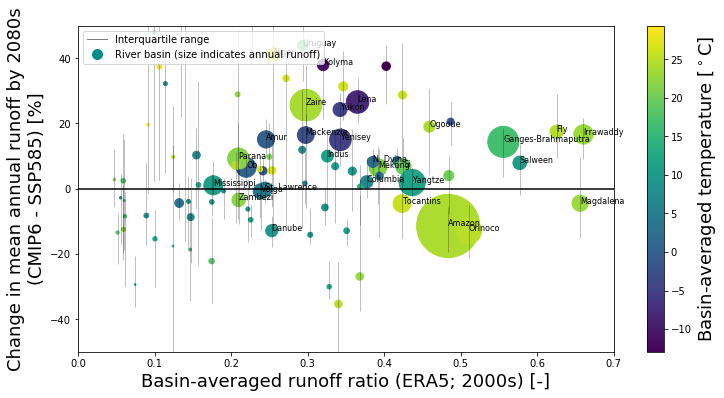

In [22]:
scatter_errorbar_plot(full_gcm_change_means_df['runoff_ratio'].values,
                     full_gcm_change_means_df['median'].values*100,
                      full_gcm_change_means_df[['upper_error', 'lower_error']].values.transpose()*100,
                      full_gcm_change_means_df.index.values,
                      full_gcm_change_means_df['mean_temp'].values-273.15,
                     full_gcm_change_means_df['mean_runoff']*100,
                      [0,0.7],
                      [-50,50],
                      'Basin-averaged runoff ratio (ERA5; 2000s) [-]',
                      'Change in mean annual runoff by 2080s\n(CMIP6 - SSP585) [%]',
                      'Basin-averaged temperature [$^\circ$C]',
                      '../figures/basin_scatter_plot_mean_changes_SSP585.svg')

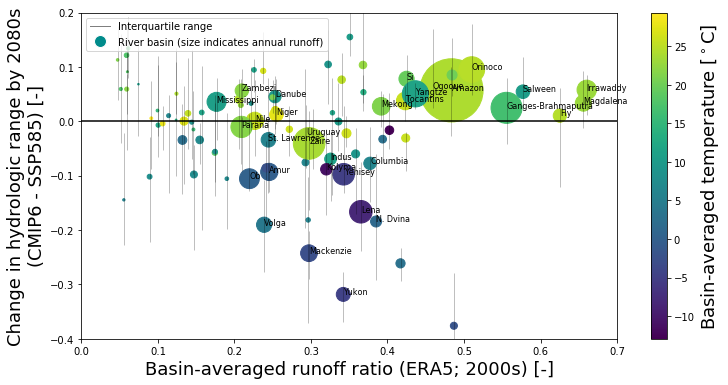

In [23]:
scatter_errorbar_plot(full_gcm_change_h_ranges_df['runoff_ratio'].values,
                     full_gcm_change_h_ranges_df['median'].values,
                      full_gcm_change_h_ranges_df[['upper_error', 'lower_error']].values.transpose(),
                      full_gcm_change_h_ranges_df.index.values,
                      full_gcm_change_h_ranges_df['mean_temp'].values-273.15,
                     full_gcm_change_h_ranges_df['mean_runoff']*100,
                      [0,0.7],
                      [-0.4,0.2],
                      'Basin-averaged runoff ratio (ERA5; 2000s) [-]',
                      'Change in hydrologic range by 2080s\n(CMIP6 - SSP585) [-]',
                      'Basin-averaged temperature [$^\circ$C]',
                      '../figures/basin_scatter_plot_h_range_changes_SSP585.svg')

# Basin-average changes mapped

In [24]:
era_basins['change in mean'] = np.nan
era_basins['change in h_range'] = np.nan

In [234]:
for basin in full_gcm_change_h_ranges_df.index.values:
    era_basins.loc[era_basins['NAME'] ==basin, 'change in h_range'] = full_gcm_change_h_ranges_df.loc[basin]['median']
    era_basins.loc[era_basins['NAME'] ==basin, 'change in mean'] = full_gcm_change_means_df.loc[basin]['median']

In [230]:
era_basins['mean'] *= 24*1000

In [ ]:
era_basins['mean']

In [248]:
era_basins[era_basins['NAME']=='Amazon']['mean']*10800

175    1019.385855
Name: mean, dtype: float64

10800.0

In [186]:
era_basins[era_basins['NAME']=='Mekong']['mean']*86400*30/10/24

101    0.468548
Name: mean, dtype: float64

In [225]:
era_basins['change in mean'] *= 100
# era_basins['change in h_range'] = np.nan

In [157]:
def add_cartopy_elements(ax):
    ax.set_global()
#     ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='black', linewidth=0.1)
    ax.add_feature(cartopy.feature.OCEAN, color='grey')
    ax.add_feature(cartopy.feature.COASTLINE, color='black', linewidth=0.1)
#     ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=0)

In [158]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


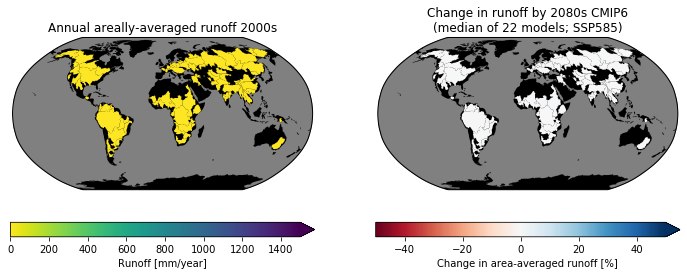

In [239]:
fig, axarr = plt.subplots(ncols=2, figsize=(12,4), 
                          subplot_kw=dict(projection=ccrs.Robinson()))
p = era_basins.plot(ax = axarr[0], column='mean', vmax=1500, vmin=0, 
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
                cmap='viridis_r',
               legend_kwds={"label": "Runoff [mm/year]",
                           "extend": "max",
                           'orientation': "horizontal"})
add_cartopy_elements(axarr[0])
p.set_title('Annual areally-averaged runoff 2000s')


p = era_basins.plot(ax = axarr[1], column='change in mean', vmax=50,
                vmin=-50, cmap='RdBu',
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
               legend_kwds={"label": "Change in area-averaged runoff [%]",
                           'extend': 'max',
                           'orientation': 'horizontal'})
p.set_title('Change in runoff by 2080s CMIP6\n(median of 22 models; SSP585)')

add_cartopy_elements(axarr[1])
# plt.tight_layout()
# fig.savefig('../figures/change_in_mean_CMIP6_basins.png', dpi=300)

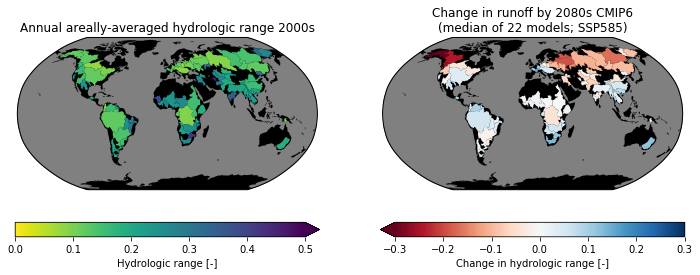

In [177]:
fig, axarr = plt.subplots(ncols=2, figsize=(12,4), 
                          subplot_kw=dict(projection=ccrs.Robinson()))

p = era_basins.plot(ax = axarr[0], column='hydrologic', vmax=0.5, vmin=0, 
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
                cmap='viridis_r',
               legend_kwds={"label": "Hydrologic range [-]",
                           "extend": "max",
                           'orientation': 'horizontal'})
add_cartopy_elements(axarr[0])
p.set_title('Annual areally-averaged hydrologic range 2000s')


p = era_basins.plot(ax = axarr[1], column='change in h_range', vmax=0.3,
                vmin=-0.3, cmap='RdBu',
            zorder=40, transform=ccrs.PlateCarree(), legend=True,
               legend_kwds={"label": "Change in hydrologic range [-]",
                           'extend': 'min',
                           'orientation': 'horizontal'})
p.set_title('Change in runoff by 2080s CMIP6\n(median of 22 models; SSP585)')

add_cartopy_elements(axarr[1])
# plt.tight_layout()
fig.savefig('../figures/change_in_h_range_CMIP6_basins_test.png', dpi=300)

In [126]:
era_basins[era_basins['NAME']=='Yukon']['h_range']

5    0.336124
Name: h_range, dtype: float64